# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 29 Νοεμβρίου 2022

**Θα βρείτε το παρόν σε μορφή jupyter notebook ως συνημμένο στο τέλος της εκφώνησης.**


In [2]:
# !pip install --upgrade pip
# !pip install --upgrade numpy
# !pip install --upgrade pandas
# !pip install --upgrade nltk
# !pip install --upgrade scikit-learn
# !pip install --upgrade joblib
# !pip install --upgrade matplotlib

# remove warnings
import warnings
warnings.filterwarnings('ignore')

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [3]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1zo13kUAf-MDMPZmBDxq1FxWtZY01lsxD"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)


Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [4]:
import numpy as np

# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 99

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1g6F4TCHrs2wgtdOk7D3gtONaeirNt_Vo"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values


titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe **corpus_df** που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [5]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Bioscope']
['"Drama"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer    
# import contractions

from nltk.tokenize import word_tokenize
import urllib.request

def get_names(url):
    decoded_url = urllib.request.urlopen(url).read().decode()
    name_list = decoded_url.split('\n')
    
    names = []
    for name in name_list:
        if name and name[0] != '#': # ignore first lines with #
            names.append(name)
    return set(names)

male_names = get_names("http://www.cs.cmu.edu/Groups/AI/util/areas/nlp/corpora/names/male.txt")
female_names = get_names("http://www.cs.cmu.edu/Groups/AI/util/areas/nlp/corpora/names/female.txt")

print('Fetched a total of '+str(len(male_names))+' Male Names.')
print('Fetched a total of '+str(len(female_names))+' Female Names.')

common_stopwords = set(stopwords.words('english'))

# uselesess words for movies
useless_words = {
    'film', 'movie', 'one', 'two', 'three', 'four',
    'five', 'six', 'seven', 'eight', 'nine', 'ten', 'first',
    'second', 'third', 'fourth', 'fifth', 'sixth', 'seventh',
    'eighth', 'ninth', 'tenth', 'story', 'protagonist', 'life',
    'character', 'plot', 'time', 'year', 'role'
}


stopwords_all = set.union(common_stopwords, useless_words, male_names, female_names)

clean_corpus = corpus_df

# remove numbers
clean_corpus[0] = clean_corpus[0].str.replace('\d+', '')
# remove punctuation and special characters
clean_corpus[0] = clean_corpus[0].str.replace('[^\w\s]','')
# use strip to remove spaces, including spaces at the beginning and the end of the string
clean_corpus[0] = clean_corpus[0].str.strip()
# convert to lowercase
clean_corpus[0] = clean_corpus[0].str.lower()
# replace any url links in corpus
clean_corpus[0] = clean_corpus[0].str.replace(r'http\S+', '')
#  example -> don't -> do not 
# clean_corpus[0] = clean_corpus[0].apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

# use word_tokenize for each row of the clean_corpus[0]
words = clean_corpus[0].apply(lambda x: word_tokenize(x))
# remove stopwords, very short words and very long words
words = words.apply(lambda x: [word for word in x if word not in stopwords_all and len(word) > 3 and len(word) < 15])

#lemmatize
wordnet_lemmatizer = WordNetLemmatizer()
words = words.apply(lambda x: [wordnet_lemmatizer.lemmatize(word) for word in x])
# concatenate words back to a sentence
clean_corpus[0] = words.apply(lambda x: ' '.join(x))



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nickvlachakis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nickvlachakis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nickvlachakis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nickvlachakis/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Fetched a total of 2943 Male Names.
Fetched a total of 5001 Female Names.


## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# fit TfidfVectorizer to corpus_df
tfidf = TfidfVectorizer()
tfidf.fit(clean_corpus[0])
# transform clean_corpus
corpus_tfidf = tfidf.transform(clean_corpus[0])


Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

In [8]:
print(corpus_tfidf.shape)

(5000, 47563)


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def content_recommender(target_movie,max_recommendations,corpus_type):
    # for target_movie calculate the cosine similarity with all other movies
    similarity = cosine_similarity(corpus_type[target_movie], corpus_type)

    # sort the similarity array in descending order
    similarity_sorted = np.sort(similarity[0])[::-1]
    # print("Similarity Sorted: ",similarity_sorted[0:max_recommendations+1])
    # print('-----------------------------')

    # get the indices of the top max_recommendations movies
    indices = np.argsort(similarity[0])[::-1][1:max_recommendations+1]
    
    print("Target Movie ID: ",target_movie)
    print("Target Movie Title: ",titles[target_movie][0])
    print("Target Movie Category: ",categories[target_movie])
    print("Target Movie Summary: ",corpus[target_movie][:500] + "...")
    print('-----------------------------')
    
    # print the titles of the top max_recommendations movies
    for i in range(0,max_recommendations):
        print("Movie ID: ",indices[i])
        print("Movie Title: ",titles[indices[i]][0])
        print("Movie Category: ",categories[indices[i]])
        print("Similarity: ",str(round(similarity[0][indices[i]] * 100, 2)) + "%")
        print("Movie Summary: ",corpus[indices[i]][:500] + "...")
        print('-----------------------------')

        
    return indices

# call the content_recommender function
indices = content_recommender(3669,3,corpus_tfidf)


Target Movie ID:  3669
Target Movie Title:  Oily Hare
Target Movie Category:  ['"Short Film",  "Family Film",  "Animation"']
Target Movie Summary:  Along Highway $101.00, approximately 531 miles from "Dollar$, Texas" and near "Deepinahearta", Texas, Bugs' rabbit hole in "Deepinahola", Texas upsets an oil tycoon, who sounds and acts like Yosemite Sam, because it isn't producing any oil. The tycoon pulls up to the hole in a green stretch limousine that is so long that it requires a long-distance telephone operator in the middle of the car to connect the tycoon to his chauffeur, Maverick, so he can tell Maverick  to stop the car. The tycoon sa...
-----------------------------
Movie ID:  2671
Movie Title:  Mutiny On The Bunny
Movie Category:  ['"Short Film",  "Family Film",  "Comedy",  "Animation"']
Similarity:  42.36%
Movie Summary:  In 18th-century England, the triple-masted schooner the "Sad Sack"  sits at the docks. Yosemite Sam's former crew member, a haggard, traumatized, disheveled 

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




### Baseline tests

We conducted some tests for several movies. Below you can find the results of our tests.

Movie ID | Result |
---|---|
100 | The recommended movies are similar to the target movie. The system recommends movies that were all dramas (among other genres), just like our target movie. We have to note that the second is an animated movie, with much different plot than our's. |
1000 | The recommended movies are not so similar to the target movie. The system recommends 2 movies that share common genres with our target movie and one that is not so similar to it. |
238 | The recommended movies are not similar to the target movie. Only one of the recommended movies shares a common genre with our target movie. The other two movies are not at all similar to our target movie. We observed that, even though the movies do not have similar genres and plot, their main character has the same name (Jackson). We believe that this is the reason why the system recommends these movies. |




In [10]:
print('Test 1:\n')
content_recommender(100,3,corpus_tfidf)
print('\n\nTest 2:\n\n')
content_recommender(1000,3,corpus_tfidf)
print('\n\nTest 3:\n\n')
content_recommender(238,3,corpus_tfidf)


Test 1:

Target Movie ID:  100
Target Movie Title:  Jacknife
Target Movie Category:  ['"Drama"']
Target Movie Summary:  Joseph Megessey  is a Vietnam war veteran suffering post-Vietnam stress syndrome who is having trouble fitting in with society. He takes on the responsibility of drawing Dave, a fellow veteran now an alcoholic, out of his shell by coaxing him to enjoy life again, as well as urging him to face up to some of his darker memories. Megs finds himself attracted to Dave's meek sister Martha, who lives with Dave and takes care of him. This attraction leads to a love affair, much to Dave's disapproval. D...
-----------------------------
Movie ID:  2494
Movie Title:  My Pal Gus
Movie Category:  ['"Drama",  "Comedy-drama",  "Comedy",  "Domestic Comedy"']
Similarity:  30.24%
Movie Summary:   Bon-bon manufacturer Dave Jennings is so focused on his Los Angeles-based business that he neglects his precocious five-year-old son Gus, who is constantly creating havoc in order to get his 

array([3751, 3524, 2873])

In [11]:

tfidf_optimized = TfidfVectorizer(max_df=0.2,min_df=0.01, stop_words=list(stopwords_all), ngram_range=(1,2))
tfidf_optimized.fit(clean_corpus[0])
corpus_tfidf_optimized = tfidf_optimized.transform(clean_corpus[0])



### Improved tests

We conducted some tests for the same movies as before, but this time we used the improved `TfidfVectorizer`. Below you can find the results of our tests.


Movie ID | Result |
---|---|
100 | As we can see, the results are much better than the baseline's. The recommended movies are still in the same genre and their plots are very similar to the target movie. All the recommended movies talk about similar topics (relationships between people) and they all make references to the vietnam war. |
1000 | The recommended movies are much closer to the target movie. The summary of the recommended movies is quite similar to the target movie. The recommended movies share common genres and they all talk about specific events that mark a significant change in the plot of the movie. |
238 | The recommended movies have much more similar plots to the target movie and all of them share common genres, comparing to the baseline's. The curent system not only avoids recommending movies that have the same character name, but also recommends movies that have similar plots. |



In [12]:
print('Test 1:\n')
content_recommender(100,3,corpus_tfidf_optimized)
print('\n\nTest 2:\n\n')
content_recommender(1000,3,corpus_tfidf_optimized)
print('\n\nTest 3:\n\n')
content_recommender(238,3,corpus_tfidf_optimized)

Test 1:

Target Movie ID:  100
Target Movie Title:  Jacknife
Target Movie Category:  ['"Drama"']
Target Movie Summary:  Joseph Megessey  is a Vietnam war veteran suffering post-Vietnam stress syndrome who is having trouble fitting in with society. He takes on the responsibility of drawing Dave, a fellow veteran now an alcoholic, out of his shell by coaxing him to enjoy life again, as well as urging him to face up to some of his darker memories. Megs finds himself attracted to Dave's meek sister Martha, who lives with Dave and takes care of him. This attraction leads to a love affair, much to Dave's disapproval. D...
-----------------------------
Movie ID:  342
Movie Title:  New Jerusalem
Movie Category:  ['"Drama"']
Similarity:  22.35%
Movie Summary:  The film focuses on the relationship between an Irish immigrant , a veteran of the U.S. war in Afghanistan, and his American co-worker, an evangelical Christian ...
-----------------------------
Movie ID:  2506
Movie Title:  In Country
Mo

array([2390,  255, 4785])

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [13]:
# !pip install -U gensim
import gensim.downloader as gensim_api
print(list(gensim_api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

#### Άλλα εμφυτεύμαατα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

In [14]:
# This block is used to download the model and store it locally. Should be run on the first time that the notebook is run 
# or every time we need to change model.


# import joblib
# model = gensim_api.load("glove-wiki-gigaword-200") # load glove twitter model of 200 dimensional vectors
# joblib.dump(model, 'model.pkl') 


In [15]:

# This block is used to load the model from the local storage. Should be run every time the notebook is run after the first time.

import joblib
model = joblib.load('model.pkl')



In [16]:
from scipy.sparse import csr_matrix


# function that returns a new corpus using the ew2v embeddings provided
def build_tfw2v(corpus, vectors, embedding_size):
    # We will use the optimal tf-idf vectorizer from the previous section. We initialize it again so that
    # this function can be run independently.
    tfidf_vectorizer = TfidfVectorizer(max_df=0.2,min_df=0.01, stop_words=list(stopwords_all), ngram_range=(1,2))
    tfidf_vectorizer.fit(corpus[0])
    corpus_tfidf = tfidf_vectorizer.transform(corpus[0])



    final_corpus = np.zeros((len(corpus), embedding_size)) 
    
    corpus_tokenized = corpus[0].apply(lambda x: word_tokenize(x))

    # iterate through each text in corpus with index
    for index, description  in enumerate(corpus_tokenized):
        w2v_numerator = np.zeros(embedding_size)
        w2v_denominator = 0
        for word in corpus_tokenized[index]:
            if word in tfidf_vectorizer.vocabulary_:
                idx = tfidf_vectorizer.vocabulary_[word] # index of word in tf-idf matrix
            else:
                continue

            word_tfidf = corpus_tfidf[index, idx] # tf-idf of word

            if word in vectors.index_to_key: # check if word exists in the Word2Vec model
                w2v_numerator += word_tfidf * vectors[word]
                w2v_denominator += word_tfidf
            else:
                continue
                
        final_corpus[index,:] = w2v_numerator/w2v_denominator

    
    return final_corpus



tfw2v_corpus = build_tfw2v(clean_corpus, vectors = model, embedding_size = model.vectors.shape[1])

In [17]:
content_recommender(100,5,corpus_tfidf_optimized)


Target Movie ID:  100
Target Movie Title:  Jacknife
Target Movie Category:  ['"Drama"']
Target Movie Summary:  Joseph Megessey  is a Vietnam war veteran suffering post-Vietnam stress syndrome who is having trouble fitting in with society. He takes on the responsibility of drawing Dave, a fellow veteran now an alcoholic, out of his shell by coaxing him to enjoy life again, as well as urging him to face up to some of his darker memories. Megs finds himself attracted to Dave's meek sister Martha, who lives with Dave and takes care of him. This attraction leads to a love affair, much to Dave's disapproval. D...
-----------------------------
Movie ID:  342
Movie Title:  New Jerusalem
Movie Category:  ['"Drama"']
Similarity:  22.35%
Movie Summary:  The film focuses on the relationship between an Irish immigrant , a veteran of the U.S. war in Afghanistan, and his American co-worker, an evangelical Christian ...
-----------------------------
Movie ID:  2506
Movie Title:  In Country
Movie Categ

array([ 342, 2506,  771, 4244, 1862])

## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nit-picking:](https://en.wikipedia.org/wiki/Nitpicking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

### Preprocessing

The preprocessing steps we took are:

- Remove all the numbers
- Remove all the punctuation
- Remove spaces from the beginning and end of the string
- Convert all characters to lowercase
- Remove URLs
- Expand contractions
- Remove stopwords (including common names, common stopwords from the english language and stopwords that are common in movie corpuses)
- Remove all the words that are less than 4 characters long
- Remove all the words that are more than 15 characters long
- Lemmatize the words


### TfidfVectorizer optimization

In order to optimize the TfidfVectorizer we tried different values for the **max_df** and **min_df** parameters. We found that the values  max_df=0.2 and min_df=0.01 worked really well for our dataset and significantly reduced the size of the vectorizer's vocabulary, making it faster to fit to our data. We also tried different values for the ngram_range parameter but we found that the best results are achieved with **ngram_range**=(1,2). Further increasing the ngram_range parameter did not improve the results, so we selected 2 as the upper bound. The lower bound had to be 1 (testing with values greater than 1 showed really bad results).

### Cherry-picking

Below we have 5 movies that the recommender system returns good results for. 

Movie ID | Movie Title | Comment
--- | --- | ---
125 | Final Destination | The recommendation system worked well for this movie, since all of the recommended movies were thrillers and action films. Four out of the five recommendations shared a common plot theme that revolved around aviation.
1254 | Larki Panjaban | The movies recommended by the system all fall in the drama genre and all of them have important Indian characters.
2000 | Hangman's Curse | All of the recommended movies share the same plot theme, which is school. In all of the movies the main characters are either students or have a connection to a school. The movies do not have so similar gernes.


In [18]:
print('Demo 1:\n')
content_recommender(125,5,corpus_tfidf_optimized)
print('\n\nDemo 2:\n\n')
content_recommender(1254,5,corpus_tfidf_optimized)
print('\n\nDemo 3:\n\n')
content_recommender(2000,5,corpus_tfidf_optimized)

Demo 1:

Target Movie ID:  125
Target Movie Title:  Final Destination
Target Movie Category:  ['"Thriller",  "Horror",  "Supernatural",  "Cult",  "Slasher",  "Teen"']
Target Movie Summary:  Alex Browning, a senior high school student, boards Volée Airlines Flight 180 with his classmates and teachers for their senior trip from John F. Kennedy International Airport in New York City to Charles de Gaulle International Airport in Paris. Before the plane takes off, Alex has a premonition that the flight will explode, killing everyone on board. As events from his vision express themselves in reality, he panics and attempts to stop the flight. The resulting commotion leads to the removal o...
-----------------------------
Movie ID:  1762
Movie Title:  Final Destination 2
Movie Category:  ['"Thriller",  "Horror",  "Supernatural",  "Cult",  "Slasher",  "Teen"']
Similarity:  37.25%
Movie Summary:  One year after the explosion of Flight 180, college student Kimberly Corman heads to Daytona Beach w

array([1400, 2012, 2191, 4090, 2335])

### Nit-picking

Below we have 5 movies that the recommender system returns bad results for.

Movie ID | Movie Title | Comment
--- | --- | ---
13 | Adwa | The recommender system did not work well for this movie, since it recommended movies that were not even in the same genre. The first two recommendations were accurate, and shared the shame gerne and similar plots (difficulties of people in African countries) with our target movie. However, the other three recommendations were completely different gernes and had plots that revolved around Italian characters and events that take place in Italy. This happens because the target movie is a documentary about some heroic victories of the Ethiopian army against the Italians, so the system is not able to understand that the movie is a documentary about Ethiopia and not a movie focused on Italy.
128 | Conqueror of Atlantis | The movies that the system recommended did not share much common ground with the target movie. Except for the first one, all the other recommendations do not have the same gerne as the target. Additionaly there is no pattern or anything common in the plots of the recommended movies.
999 | Bioscope | Same as the previous example, the recommended movies were not so similar to the target. Only the first one had similarities in the plot, but other than that none of the movies satisfied us.



In [19]:
print('Demo 1:\n')
content_recommender(13,5,corpus_tfidf_optimized)
print('\n\nDemo 2:\n\n')
content_recommender(128,5,corpus_tfidf_optimized)
print('\n\nDemo 3:\n\n')
content_recommender(999,5,corpus_tfidf_optimized)

Demo 1:

Target Movie ID:  13
Target Movie Title:  Adwa
Target Movie Category:  ['"Documentary"']
Target Movie Summary:  In 1896, Ethiopia, largely armed with spears and knives, defeats a well-equipped and organized Italian military bent on colonization. On March 2, 1896, the Italians embarked on the final European conquest of an African nation, Ethiopia. With brilliant military intelligence and gallant generals at the helm, united and willed, the Ethiopian people rose their way to triumph over the Italians at the Battle of Adwa. The event ignited a lasting flame of hope, of freedom and independence in the hearts ...
-----------------------------
Movie ID:  2263
Movie Title:  500 Years Later
Movie Category:  ['"History",  "Indie",  "Documentary"']
Similarity:  40.4%
Movie Summary:  Crime, drugs, HIV/AIDS, poor education, inferiority complex, low expectation, poverty, corruption, poor health, and underdevelopment plagues people of African descent globally. 500 years later from the onset

array([4291, 1818, 1050, 3500,  884])

### Tfidf based recommender pros and cons

|Pros|Cons|
|---|---|
|It can handle synonyms and polysemy well | The vectors can be very large, take up lots of space |
|It's easy to calculate the similarity of two documents | It may not handle sparse data well|
|It can handle large datasets,the training times are not so large | TF-IDF is based on the bag-of-words (BoW) model, therefore it does not capture position in text, semantics, co-occurrences in different documents, et|
| |Cannot capture semantics|


### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Καθώς στην δεύτερη εργασία καλείστε να δημιουργήσετε διάφορα corpora των οποίων η δημιουργία παίρνει χρόνο, υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [20]:
# import joblib

# joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [21]:
# !ls -lh

και μπορούμε να τα διαβάσουμε με `joblib.load`

In [22]:
# corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [23]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

In [24]:
my_best_corpus = corpus_tfidf_optimized
final_set = build_final_set(my_best_corpus)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [25]:
final_set.shape

(5000, 2424)

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [26]:
# install somoclu
# !pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

If you installed Somoclu with pip on macOS, this typically means missing a linked library. If you compiled Somoclu with GCC, please make sure you have set DYLD_LIBRARY_PATH to include the GCC path. For more information, please refer to the documentation.


Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

In [27]:
# import time

# subset = build_final_set(my_best_corpus, doc_limit=2000)
# rows,columns = 10,10
# epochs = 100
# som = somoclu.Somoclu(columns, rows, compactsupport=False)

# start = time.time()
# som.train(subset, epochs = epochs)
# end = time.time()
# print("Training time: %.2f seconds" % (end - start))



In [28]:
# joblib.dump(som, 'som.pkl')
som = joblib.load('som.pkl')


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [29]:
bmus, indices = np.unique(som.bmus,axis=0,return_index=True)


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [34]:
from sklearn.cluster import KMeans
som.cluster(KMeans(n_clusters=20))


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [36]:
# joblib.dump(som, 'som.pkl') 
som = joblib.load('som.pkl')


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



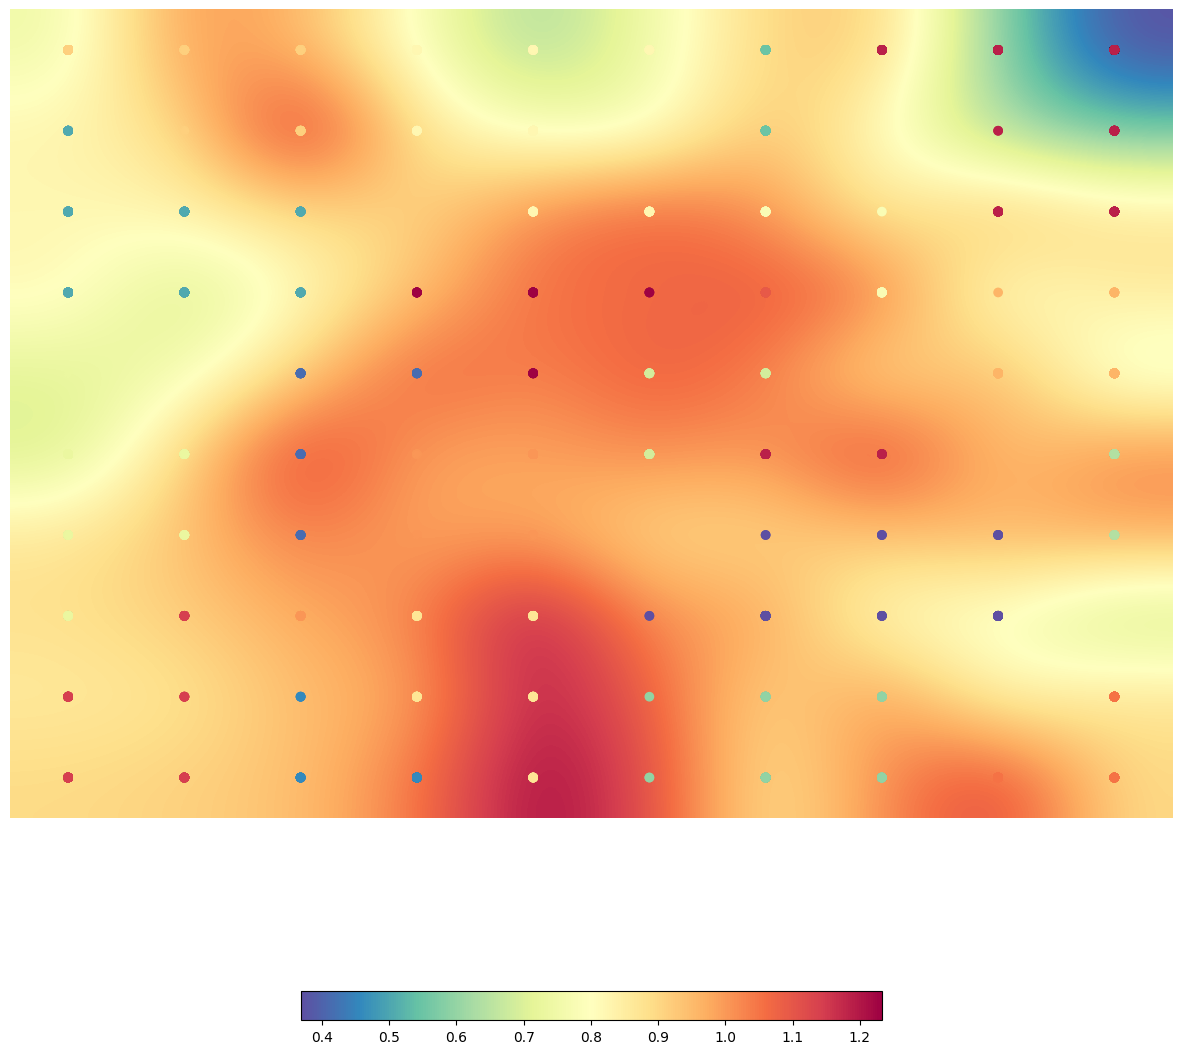

In [37]:
som.view_umatrix(bestmatches=True, colorbar=True,figsize=(15, 15))
matplotlib.pyplot.show()

In [80]:
# clustering visualization by printing the clusters variable
print(som.clusters)
print("-------------------------------------")
# returns a set with keys being the cluster labels and values being the number of elements in each cluster with values sorted in ascending order
clusters, counts = np.unique(som.clusters, return_counts=True)
sorted_counts = np.argsort(counts)
cluster_counts = {clusters[i]: counts[i] for i in sorted_counts}
print(cluster_counts)



[[12 12 12 10 10 10  4 18 18 18]
 [ 3 12 12 10 10 10  4  4 18 18]
 [ 3  3  3  3 10 10  9  9 18 18]
 [ 3  3  3 19 19 19 16  9 13 13]
 [ 8  3  1  1 19  7  7 13 13 13]
 [ 8  8  1 14 14  7 18 18  6  6]
 [ 8  8  1 14 14 14  0  0  0  6]
 [ 8 17 14 11 11  0  0  0  0 15]
 [17 17  2 11 11  5  5  5 15 15]
 [17 17  2  2 11  5  5  5 15 15]]
-------------------------------------
{16: 1, 9: 3, 2: 3, 7: 3, 4: 3, 6: 3, 19: 4, 1: 4, 11: 5, 12: 5, 13: 5, 15: 5, 17: 5, 8: 6, 14: 6, 5: 6, 0: 7, 10: 8, 3: 9, 18: 9}



## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.



# Τελική παράδοση άσκησης

- Θα παραδώσετε στο helios το παρόν notebook επεξεργασμένο ή ένα ή δύο νέα zipαρισμένα με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα</font>
</td>
  </tr>
</table>